In [1]:
#!pip3 install cartopy
#!pip3 install pycountry_covert
#import pycountry_convert as pc
#!pip install import wget
#!pip install adjustText
import cartopy.crs as ccrs
import re
import os
import requests
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import urllib
import geopandas as gpd
import geopandas as gpd
from zipfile import ZipFile
from shapely.geometry import Point
import matplotlib.pyplot as plt
import fiona
import adjustText as aT
import mapclassify


#### ***getISO3code*** 
- This is a functionm to get the ISO-3 country codes.
- The function is required for propper functioning of ***getGADMdata *** below.

In [2]:
# a function to get all the ISO3 coundtry codes from wikipedia

def getISO3code(country = None, table = None):
    
    link = "https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3"
    session = urlopen(link)
    read_page = session.read().decode("utf-8")

    soup = BeautifulSoup(read_page, "html.parser")

    ISO_3 = soup.find_all("span", class_="monospaced")

    full_name = soup.find_all('a', title=True)


    ISO_3_code =[]

    names = []


    # get ISO codes

    for i in ISO_3:
        for child in i.descendants:
            ISO_3_code.append(child)
    
    #The data starts with Aruba nd ends with Zimbabwe
    for i in range(len(ISO_3_code)):

        if ISO_3_code[i] == "ABW":

            start_ISO = i

        elif ISO_3_code[i] == "ZWE":

            end_ISO = i       

    ISO3_complete = ISO_3_code[start_ISO:end_ISO+1]

   
    # Get the full names corresponding to each code
    
    for name in full_name:

        for child in name.descendants:

            names.append(child)


        
 # grab start and end of country names       


    for i in range(len(names)):
        if names[i] == "Aruba":
            start_name = i
        elif names[i] == "Zimbabwe":
            end_name =i
            
    fullNames = names[start_name:end_name+1]
    fullNames.remove('Province of China')
    
    data = pd.DataFrame(
    {'Country_name': fullNames,  'ISO3_Code':ISO3_complete}
    )
    
    exception_countries = ["Bolivia (Plurinational State of)", 
                            "Cocos (Keeling) Islands", 
                            "Falkland Islands (Malvinas)",
                            "Micronesia (Federated States of)",
                            "United Kingdom of Great Britain and Northern Ireland",
                            "Iran (Islamic Republic of)",
                            "Saint Martin (French part)",
                            "Korea, Republic of",
                            "Korea (Democratic People's Republic of)",
                            "Sint Maarten (Dutch part)",
                            "Venezuela (Bolivarian Republic of)",
                           ]
    common_name = ["Bolivia",
                   "Cocos Islands",
                   "Falkland Islands",
                   "Micronesia",
                   "United Kingdom",
                   "Iran",
                   "Saint Martin",
                   "South Korea",
                   "North Korea",
                   "Sint Maarten",
                   "Venezuela",]

    
    for rare_name, common_name in zip(exception_countries,common_name):
        data = data.replace(rare_name,common_name)
    
    if country:
        if table:
            return data[data.Country_name==country]
        else:
            return str(data[data.Country_name==country].iloc[0,1])
    else:
        return data

    
    

In [3]:

getISO3code("United Kingdom")

'GBR'

#### ***getGADMdata*** is a function to rietrive administrative boundaries (upto level 3). The function is based on FAO GADM version 3.6 boundary data.

**Available formats**

- The ***"geopackage"*** format is the a very good general spatial data file format (for vector data). It is based on the SpatiaLite format, and can be read by software using GDAL/OGR, including R (with the 'sf' package), QGIS and ArcGIS you can specify this package like this (*file_format = 'gpkg'*).

- A ***"shapefile"*** consist of at least four actual files (.shp, .shx, .dbf, .prj). This is an obsolete, but still commonly used format that can be directly used in a lot of software such as ArcGIS and DIVA-GIS, and many other programs(*file_format = 'shp'*).

- "R sp" and "sf ***(.rds)*** and ***(.kmz)*** formats have not been implemented

- To be implemented: the natural earth level 0 country boundaries for the entire world.

In [4]:

# retrieves the FAO GADM boundary data, level 3. the code is based on version 3.6 of the data

def getGADMdata(country = None, level= None, file_format = None):
    current_dir = os.getcwd()
    
    base_url = "https://biogeo.ucdavis.edu/data/gadm3.6/"
    
    if country:
        file_name = f'{country}_level3_Admin.zip'

        file_path = current_dir + "/" + file_name

        
        roi = getISO3code(f'{country}')
        link = base_url + str(file_format) + "/" +"gadm36_" + roi + "_" + str(file_format) +".zip"
        link = re.sub("None", "", link)
        
        print(f"downloading {country} Admin level {level} data from {link}")
        
    
            
        if file_format == "shp":
            
                if os.path.exists(file_path):
                    # Unzip the downloaded file and read it inton python

                    with ZipFile(file_path, 'r') as zipObj:
                        # Extract all the contents of zip file in current directory
                        zipObj.extractall()
                    
                    file_path = f'{current_dir}/gadm36_{roi}_{level}.{file_format}'
                    file_path = re.sub("None", "", file_path)
                    gpd_df = gpd.read_file(file_path)
                #return gpd_df[gpd_df.NAME_0 == country]
                else:
                    print(f"downloading data from {link}")
                
                    urllib.request.urlretrieve(link, file_path)
                    # Unzip the downloaded file and read it inton python
                    
                    with ZipFile(file_path, 'r') as zipObj:

                        # Extract all the contents of zip file in current directory
                        zipObj.extractall()
                    
                    file_path = f'{current_dir}/gadm36_{roi}_{level}.{file_format}'
                    file_path = re.sub("None", "", file_path)
                
                    gpd_df = gpd.read_file(file_path)
                    #gpd_df = gpd_df[gpd_df.NAME_0 == country]
        
        else: 
            if os.path.exists(file_path):
                file_path = f'{current_dir}/gadm36_{roi}.{file_format}'
                file_path = re.sub("None", "", file_path)
                gpd_df = gpd.read_file(file_path)
            else:
                print(f"downloading data from {link}")
                
                urllib.request.urlretrieve(link, file_path)
                file_path = f'{current_dir}/gadm36_{roi}.{file_format}'
                file_path = re.sub("None", "", file_path)
                gpd_df = gpd.read_file(file_path)
                
    return gpd_df
        
        
   

downloading Saudi Arabia Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SAU_shp.zip


<AxesSubplot:>

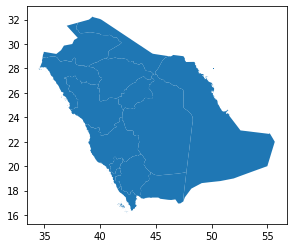

In [5]:
# Implementation 
oman = getGADMdata(country = "Saudi Arabia", file_format = "shp", level = "1")
oman.plot()

#### Computing the sum of treated areas for each country in (ha)
- Read in the csv file with the row point data information.
- Group the data by the country column and then compute the sum of the treated areas per country.

In [42]:

csv_data_2019_2021 = pd.read_csv("../Decrypted/DL_Treatment_data_More_precise_Location2.csv")
csv_data_2003_2005 = pd.read_csv("/Users/rragankonywa/OneDrive/UniWurzburg/EAGLES/Semester3/Internship/DLR_Internship/Internship/week1/2003_2005/Unlocked/2003_205_DL_Treatment_data1.csv")

def rename_country(csv_file,old_names, new_names):
    for old_name, new_name in zip(old_names,new_names):
        csv_file = csv_file.replace(old_name,new_name)
    return csv_file

#rename_country(csv_data_2019_2021, ['Islands', 'Arabia','Jamahiraya'], ['Cape Vade Islans','Saudi Arabia', 'Libya'])


#csv_data_2019_2021 = csv_data_2019_2021.replace("ARABIA","SAUDI ARABIA")


# group the data by the country colum and compute the sum
def group_by_treatedArea(csv_file):

    country_sum = csv_file.groupby(["Country"],as_index = False).sum()

    # Capitalize the country names to match the naming in the global data
    # drop the year information
    country_sum["Country"] = country_sum["Country"].str.title()
    country_sum = country_sum.drop(["Year"],axis=1)

    #change the country name column to match the naming on the global dataset
    country_sum = country_sum.rename(columns = {'Country': "SOVEREIGNT"})
    return country_sum

In [48]:
csv_data_2003_2005 = rename_country(csv_file = csv_data_2003_2005, old_names =['Islands', 'Arabia','Jamahiriya'], new_names =['Cape Vade Islands','Saudi Arabia', 'Libya'])
csv_data_2019_2021 = rename_country(csv_file = csv_data_2019_2021, old_names =['ARABIA'], new_names =['Saudi Arabia'])

In [59]:
country_sum_2003_2005=group_by_treatedArea(csv_data_2003_2005)
country_sum_2019_2021=group_by_treatedArea(csv_data_2019_2021)
country_sum_2019_2021

,SOVEREIGNT,T_area (ha)
0,Afghanistan,2969
1,Algeria,1435
2,Djibouti,65
3,Egypt,22514
4,Eritrea,117607
5,Ethiopia,1437105
6,India,639150
7,Iran,1017206
8,Iraq,2750
9,Jordan,4700


#### Join the csv data (the computed sum above) with the level 0 admin boundary polygons from natural earth
- Do a spatial joint based on the country name column ('SOVEREIGNT') which is a common field in both datasets.

In [52]:
# load level 0 country plot and join it with the country_sum based on the SOVEREIGNT column
def join_treated_sum_with_adminboundary(country_sum):
    world_leve0_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

    world_leve0 = gpd. read_file(world_leve0_path)
    #world_leve0.plot()

    world_level_0_country_sum_joined = world_leve0.join(country_sum.set_index('SOVEREIGNT'), on='SOVEREIGNT')
    
    return world_level_0_country_sum_joined

world_level_0_country_sum_joined_2003_2005 = join_treated_sum_with_adminboundary(country_sum_2003_2005)
world_level_0_country_sum_joined_2019_2021 = join_treated_sum_with_adminboundary(country_sum_2019_2021)

#### Make point_vector data from all the collected location information
- In the csv_data that was previously loaded, there are the columns all_Nothing and all_Eastings which contain all the northings and Eastings available from FAO for each month and for each country.This information is stored as a list for each month (each month could have multiple locations mentioned). The goal of the code below is to extract each point and convert it into a proper geolocation (geopandas point dataframe) for visualization.
- These points represents the locations where Desert Locusts (DL) have been spoted or treated (based on FAO monthly reports)

In [25]:
# Read the csv file and grab all the location data in the columns: all_Nothings and all_Easting and convert them
# to point vector data
#csv_data = pd.read_csv("../Decrypted/DL_Treatment_data_More_precise_Location2.csv")
#csv_data
def FAOreport_to_point(csv_file):
    lat = []
    lon = []
    countries = []
    months = []
    Years =[]

    for i in range(csv_file.shape[0]):
        year = csv_file.loc[i][0]
        month = csv_file.loc[i][1]
        country = csv_file.loc[i][2]


        all_North_monthly = csv_file.loc[i][3] 
        all_East_monthly = csv_file.loc[i][4] 



        points_lat = re.findall(r"[A-Z0-9]+",all_North_monthly) # just get the numbers and do not keep N/S this is becauswe all countries of interest are all in ther northern hemisphere
        points_lon = re.findall(r"[A-Z0-9]+",all_East_monthly) # keep the East/West information as some countries lie in the west of greenwitch. the coordinates will be assined to negative in that case


        for location_lat,location_lon  in zip(points_lat,points_lon):
            if country == "ARABIA" or country == "Arabia":
                countries.append("SAUDI ARABIA".title())
            else:
                countries.append(country)

            months.append(month)
            Years.append(year)

            #y_coord = float(location_lat[0:2] + "." + location_lat[2:4])
            #lat.append(y_coord)

            # check if the location in the west of GWM and assign -ve value else leave it as it is and only insert point.

            if location_lon[-1] == "W":
                x_coord = location_lon[0:-1]
                x_coord = float("-" + x_coord[0:2] + "." + x_coord[2:4])
                lon.append(x_coord)
            else:
                x_coord = location_lon[0:-1]
                x_coord = float(x_coord[0:2] + "." + x_coord[2:4])
                lon.append(x_coord)

            if location_lat[-1] == "S":
                x_coord1 = location_lat[0:-1]
                x_coord1 = float("-" + x_coord1[0:2] + "." + x_coord1[2:4])
                lat.append(x_coord1)
            else:
                x_coord1 = location_lat[0:-1]
                x_coord1 = float(x_coord1[0:2] + "." + x_coord1[2:4])
                lat.append(x_coord1)



    point_vector_data = pd.DataFrame(
       {'Year': Years, 'Month': months, 'Country': countries, 'Lat': lat, 'Lon': lon}
    )
    return point_vector_data
#point_vector_data

In [53]:
point_vector_data_2003_2005 = FAOreport_to_point(csv_data_2003_2005)
point_vector_data_2019_2021 = FAOreport_to_point(csv_data_2019_2021)

<AxesSubplot:>

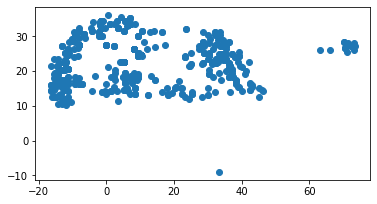

In [71]:
# Covert the above created point data into geopanda dataframe
def csv_to_gdf(point_data):
    geometry = [Point(xy) for xy in zip(point_data.Lon, point_data.Lat)]

    # drop the lon lat columns
    df = point_data.drop(['Lon', 'Lat'], axis=1)

    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    
    return gdf


gdf_2003_2005 = csv_to_gdf(point_vector_data_2003_2005)
gdf_2019_2021 = csv_to_gdf(point_vector_data_2019_2021)

gdf_2003_2005.plot()

#### Distribution of total treated areas by country
- Visualize the joined data

In [58]:
# Select countries with treated areas and grab their names. Plot their names at the centre of the polygon as text.

def treated_country_name(data):
    selected_rows = data[~data['T_area (ha)'].isnull()]


    selected_rows["center"] = selected_rows["geometry"].centroid
    
    #selected_rows["rep"] = selected_rows["geometry"].representative_point()

    selected_rows_points = selected_rows.copy()
    
    selected_rows_points.set_geometry("center", inplace = True)
    
    return (selected_rows_points)
    

In [107]:
def plot_teatment_sum_per_country (point, polygon, area, period):

    minx, miny, maxx, maxy = point.total_bounds


    ax = point.plot(figsize=(20,15),color='grey', zorder=2,legend=True)

    classi = mapclassify.UserDefined(
        polygon['T_area (ha)'], [0,100,1000,5000, 100000, 1000000, 2000000]
    )


    mapping = dict([(i,s) for i,s in enumerate(classi.get_legend_classes())])
    mapping

    def replace_legend_items(legend, mapping):
        for txt in legend.texts:
            for k,v in mapping.items():
                if txt.get_text() == str(k):
                    txt.set_text(v)



    #f, ax = plt.subplots(1, figsize=(16, 9))
    polygon.assign(cl=classi.yb).plot(column='cl', categorical=True, \
            k=10, cmap='PuRd',linewidth=0.1, ax=ax, \
            edgecolor='lightgrey', legend=True,
                              legend_kwds={'title': "Treated Area in Hacters",'loc': 'lower right'})
    #ax.set_axis_off()
    
    if period == "2003-2005":
        ax.set_xlim(minx-5, maxx +20)
        ax.set_ylim(miny, maxy+5)
    else:
        ax.set_xlim(minx-5, maxx +20)
        ax.set_ylim(miny-5, maxy-30)
    ax.set_title(f"Total Area Treated with Pesticide to Control Desert Locust during {period} Outbreak.")
    
    selected_rows_points = treated_country_name(polygon)

    texts_countryName = []
    texts_treatmentArea = []
    
    if area == True:
        field = "T_area (ha)"
    else:
        field = "SOVEREIGNT"

  

    for x, y, label in zip(selected_rows_points.geometry.x, selected_rows_points.geometry.y, selected_rows_points[field]):
        texts_treatmentArea.append(plt.text(x, y, label, fontsize = 8))

    aT.adjust_text(texts_treatmentArea, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))


    replace_legend_items(ax.get_legend(), mapping)
    plt.show()

<ipython-input-58-dea3b6d71ddb>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  selected_rows["center"] = selected_rows["geometry"].centroid
/Users/rragankonywa/opt/anaconda3/envs/GEE/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


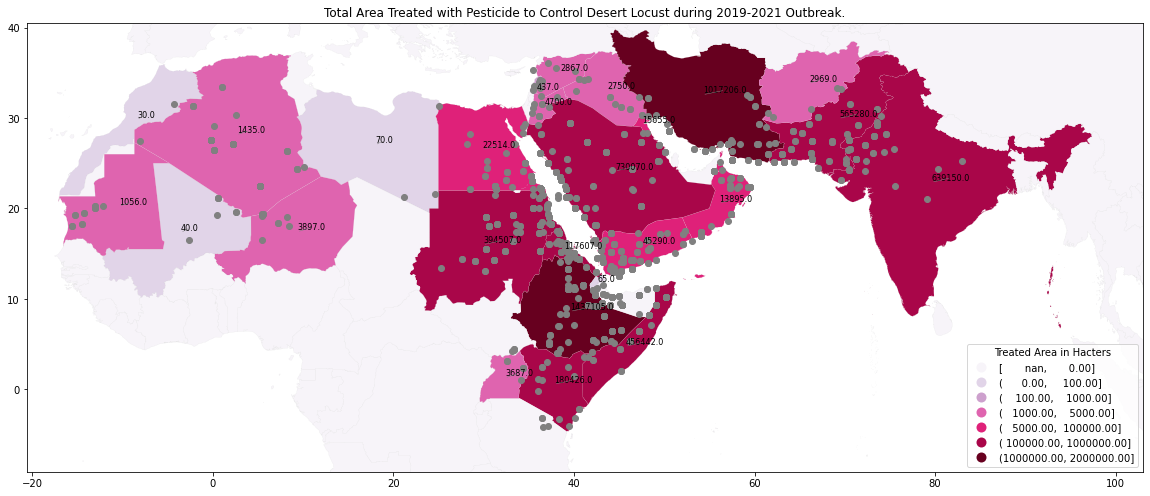

<ipython-input-58-dea3b6d71ddb>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  selected_rows["center"] = selected_rows["geometry"].centroid
/Users/rragankonywa/opt/anaconda3/envs/GEE/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


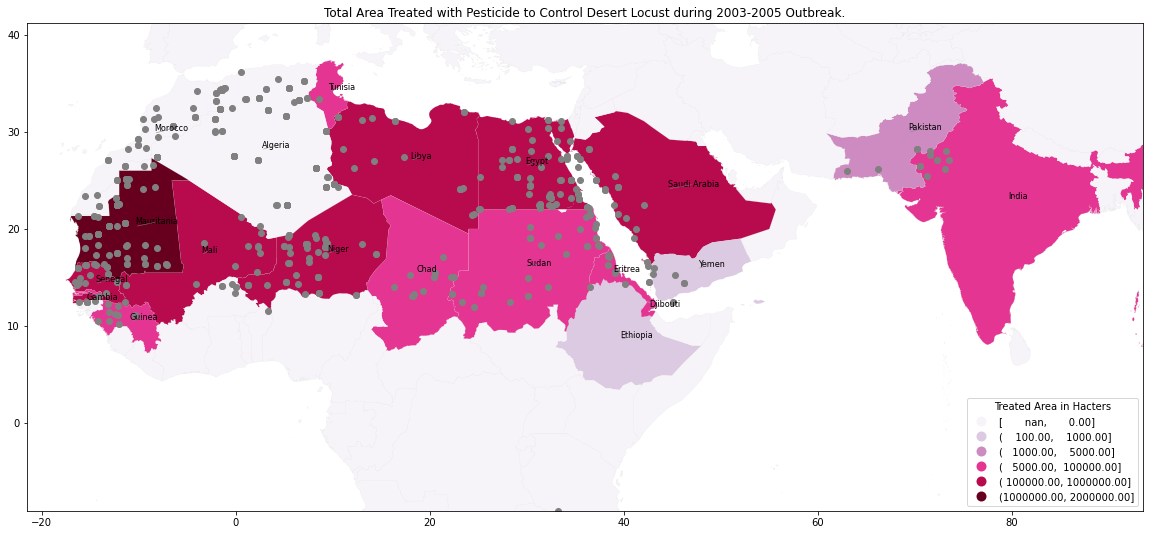

In [108]:
plot_teatment_sum_per_country(point = gdf_2019_2021, polygon = world_level_0_country_sum_joined_2019_2021,period = "2019-2021", area =True)

plot_teatment_sum_per_country(point = gdf_2003_2005, polygon = world_level_0_country_sum_joined_2003_2005,period = "2003-2005", area =False)

#### Visualize How the point data is distributed in countries recording high treatments (the yelow regions in total treated reas by country figure).

In [102]:
# Make a function to plot specific country

def countryPlot(point, country, period):
    
    polygon = getGADMdata(country = country, file_format = "shp", level = "1")
    polygon = polygon.set_crs(epsg=4326, inplace=True)
    
    
    polygon["center"] = polygon["geometry"].centroid
    #polygon["rep"] = polygon["geometry"].representative_point()
    polygon_with_points = polygon.copy()
    polygon_with_points.set_geometry("center", inplace = True)
    #polygon_with_points.set_geometry("rep", inplace = True)


#     world_level_0_country_sum_joined_points
#     ax = world_level_0_country_sum_joined.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
    texts = []

    
    
    points = gpd.clip(point, polygon)
    points['Year'] = points['Year'].astype(str)
    
    points = points.set_crs (epsg=4326, inplace=True)
    fig, ax = plt.subplots(figsize=(20,15))
    
    
    
    polygon.plot(ax=ax, 
         facecolor='lightgrey',
         edgecolor='grey',
         #linewidth = 0.5,
         #color='k', 
         zorder=1,
         alpha=1,
         linewidth=1)
    
    if period == "2003-2005":
        yearPalette = {'2005': 'darkred',
                       '2004': 'red',
                       '2003': 'coral'}
    else:
        yearPalette = {'2021': 'darkred',
                       '2020': 'red', 
                       '2019': 'coral'}
    
    for year, data in points.groupby('Year'):
        color = yearPalette[year]
        label = year
        data.plot(color=color,
                  ax=ax,
                  label=label,
                  markersize=100)

    
    ax.set_title(f"{period} Desert Locust Treatment Locations in {country}.")
    ax.legend(loc=("upper right"),
          fontsize=15,
          frameon=True,
          title="Legend")
    
    
    for x, y, label in zip(polygon_with_points.geometry.x, polygon_with_points.geometry.y, polygon_with_points["NAME_1"]):
        texts.append(plt.text(x, y, label, fontsize = 8))

    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    plt.show

downloading Ethiopia Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_ETH_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


downloading Mauritania Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_MRT_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


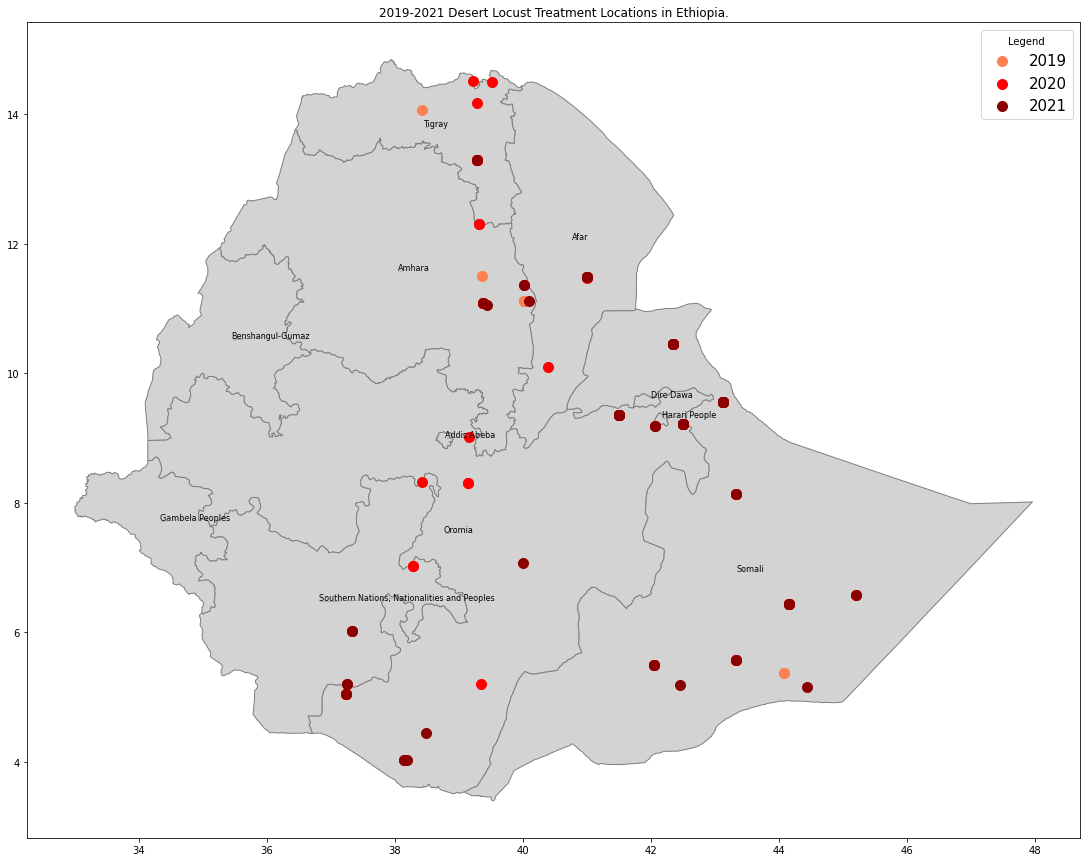

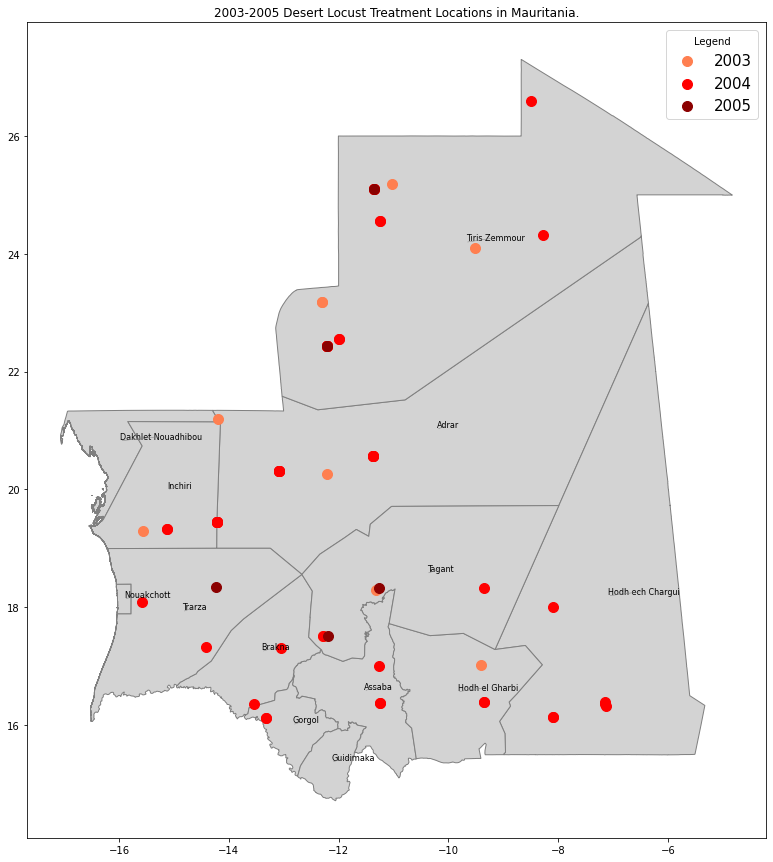

In [103]:
countryPlot(point = gdf_2019_2021,country = "Ethiopia", period = "2019-2021")
countryPlot(point = gdf_2003_2005,country = "Mauritania", period = "2003-2005")

downloading Saudi Arabia Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SAU_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


downloading Saudi Arabia Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SAU_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


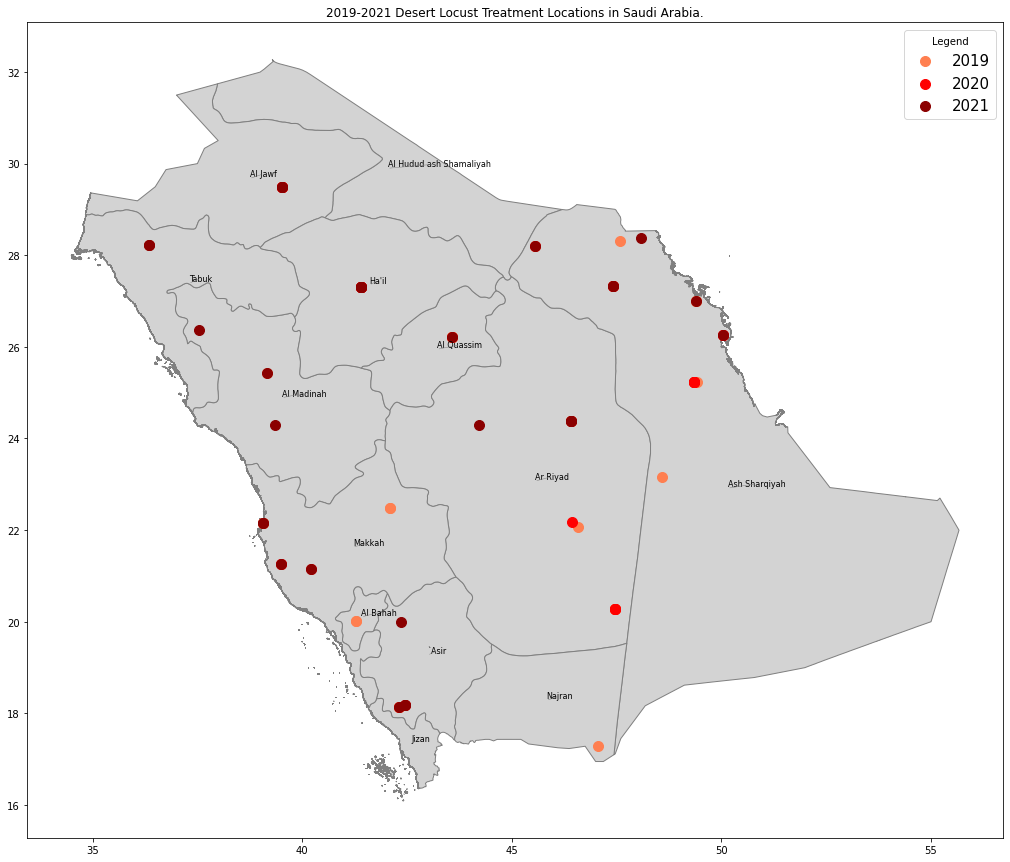

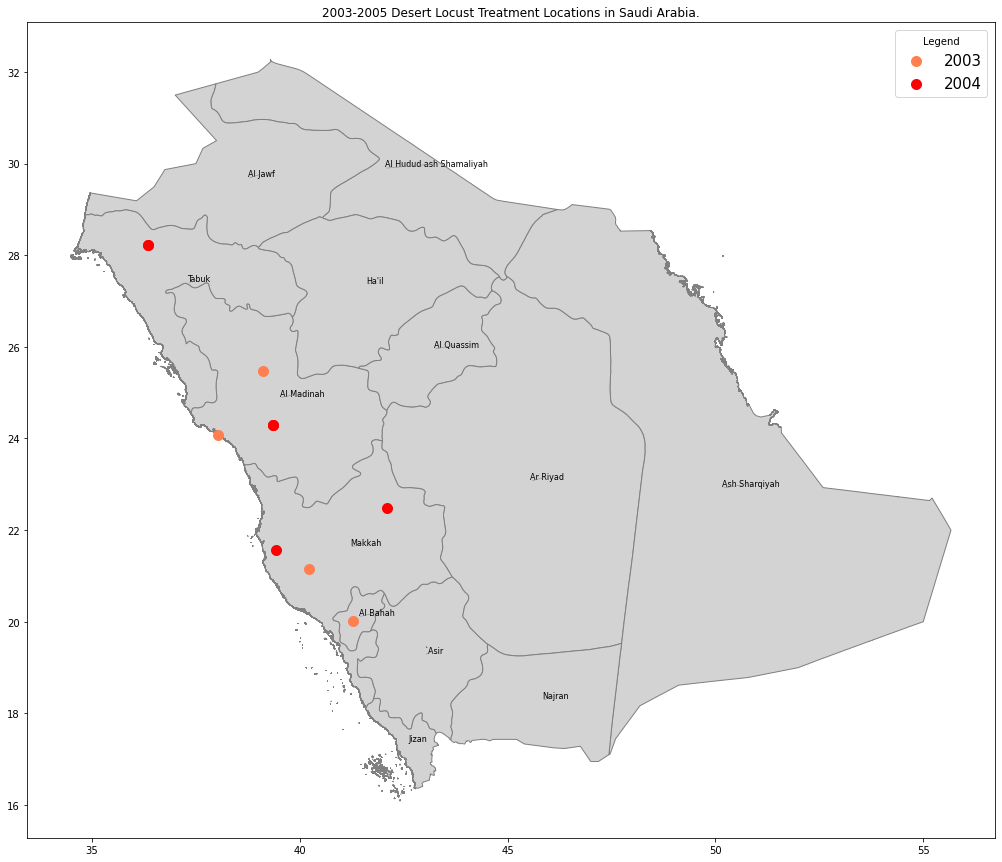

In [104]:
#countryPlot("Saudi Arabia", period ="2019-2021")
countryPlot(point = gdf_2019_2021,country = "Saudi Arabia", period = "2019-2021")
countryPlot(point = gdf_2003_2005,country = "Saudi Arabia", period = "2003-2005")

downloading Iran Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IRN_shp.zip


<ipython-input-13-cb50446d6f42>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


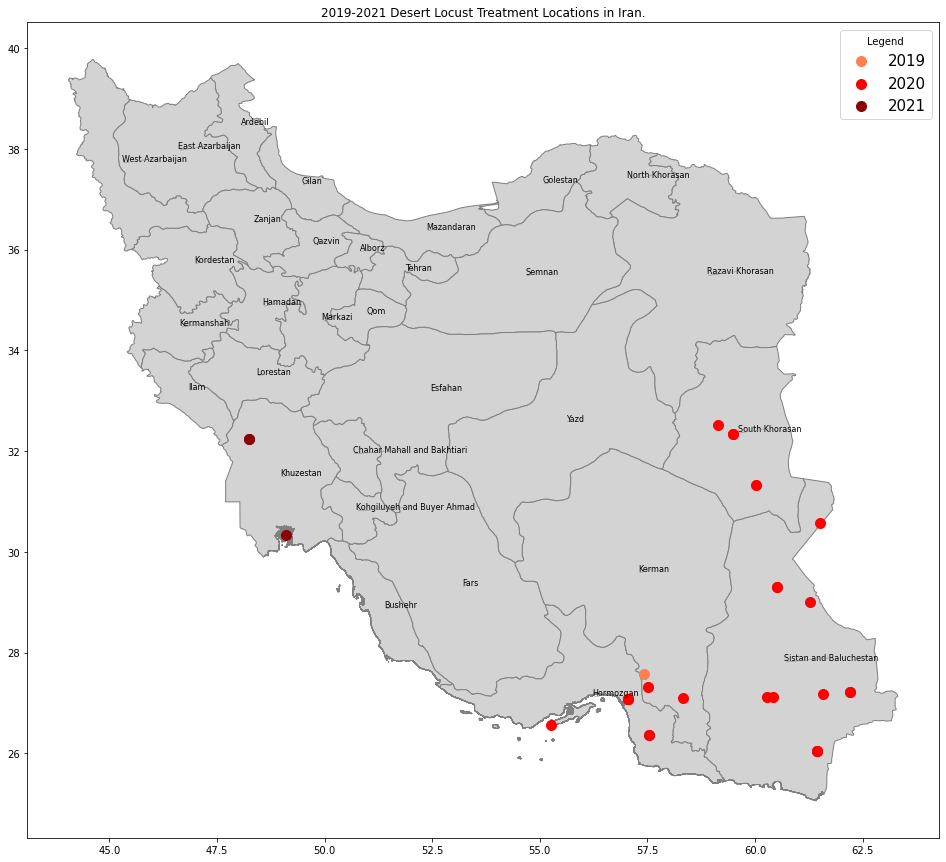

In [16]:
countryPlot("Iran", period = "2019-2021")

downloading India Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


downloading India Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


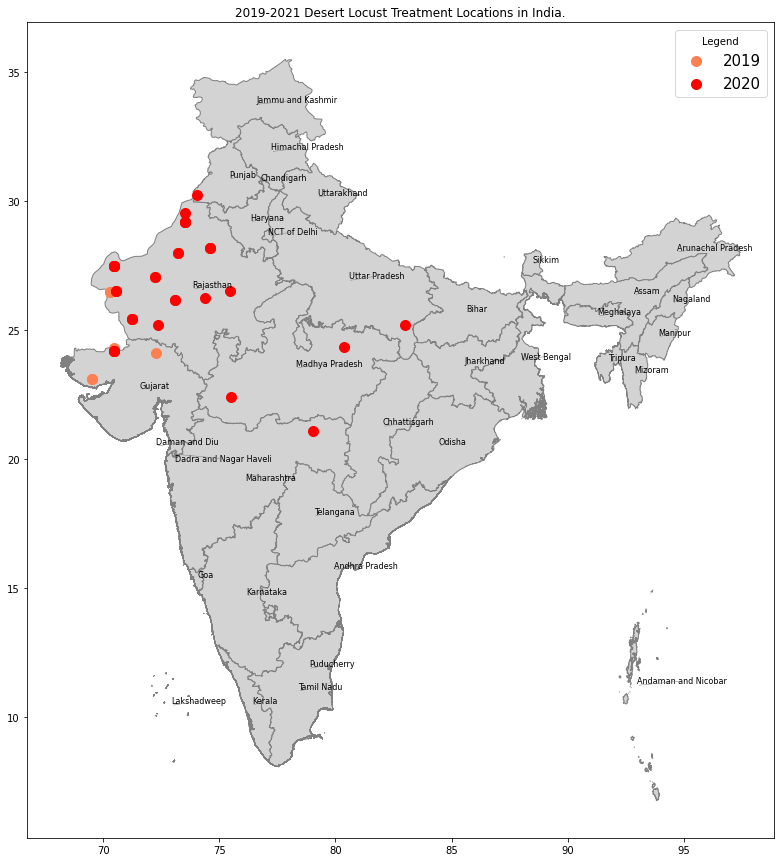

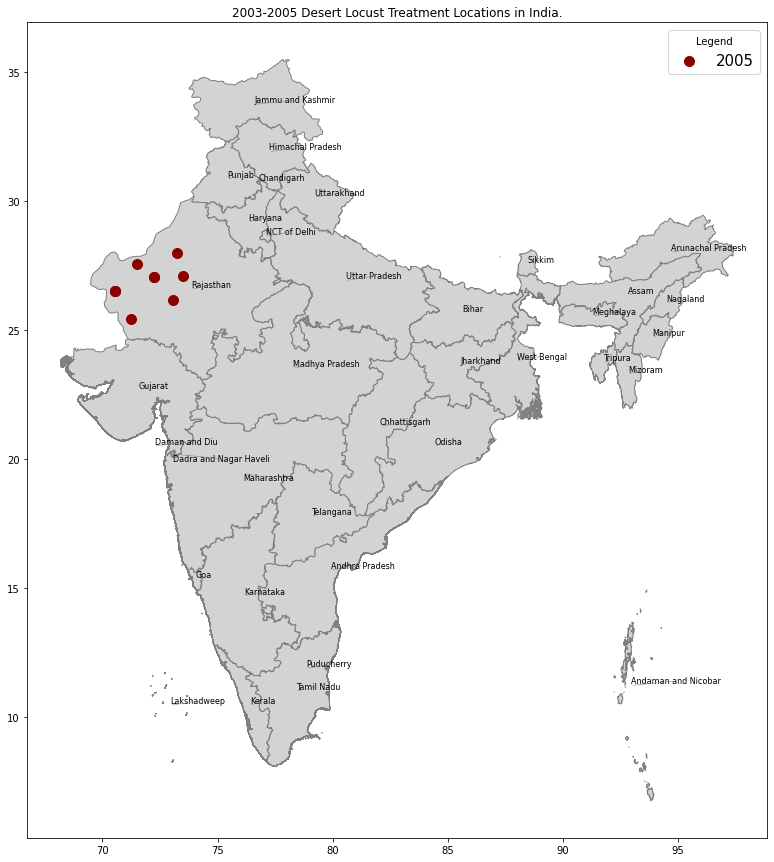

In [105]:
countryPlot(point = gdf_2019_2021,country = "India", period = "2019-2021")
countryPlot(point = gdf_2003_2005,country = "India", period = "2003-2005")

downloading Pakistan Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_PAK_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


downloading Pakistan Admin level 1 data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_PAK_shp.zip


<ipython-input-102-9b118f7e1e1d>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon["center"] = polygon["geometry"].centroid


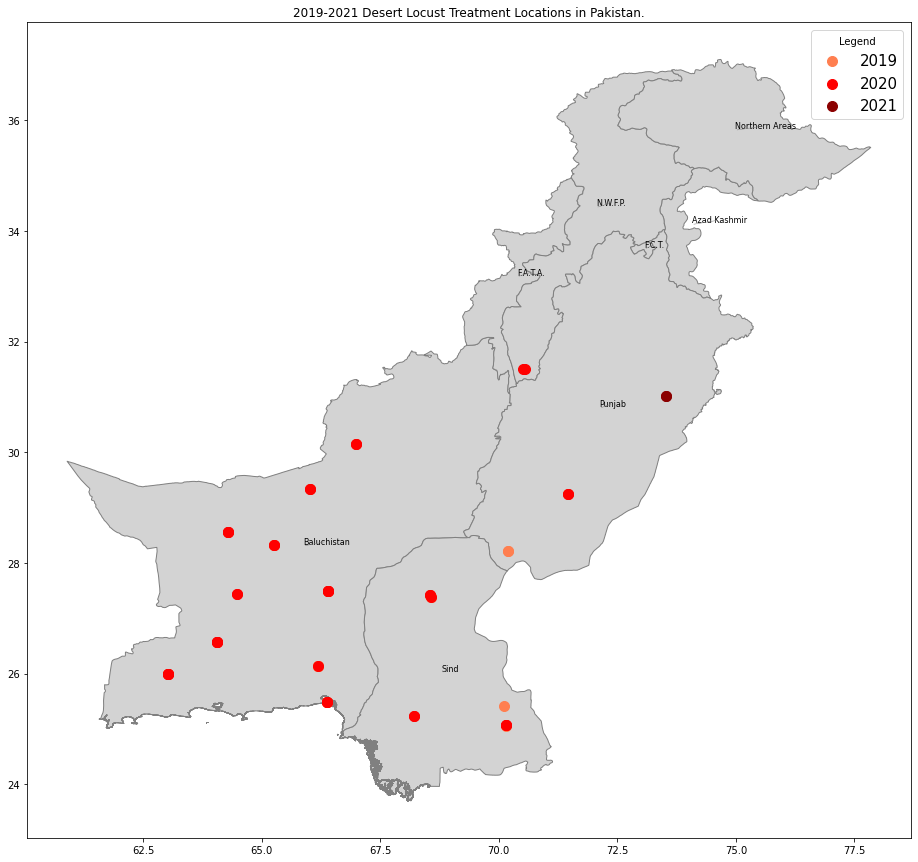

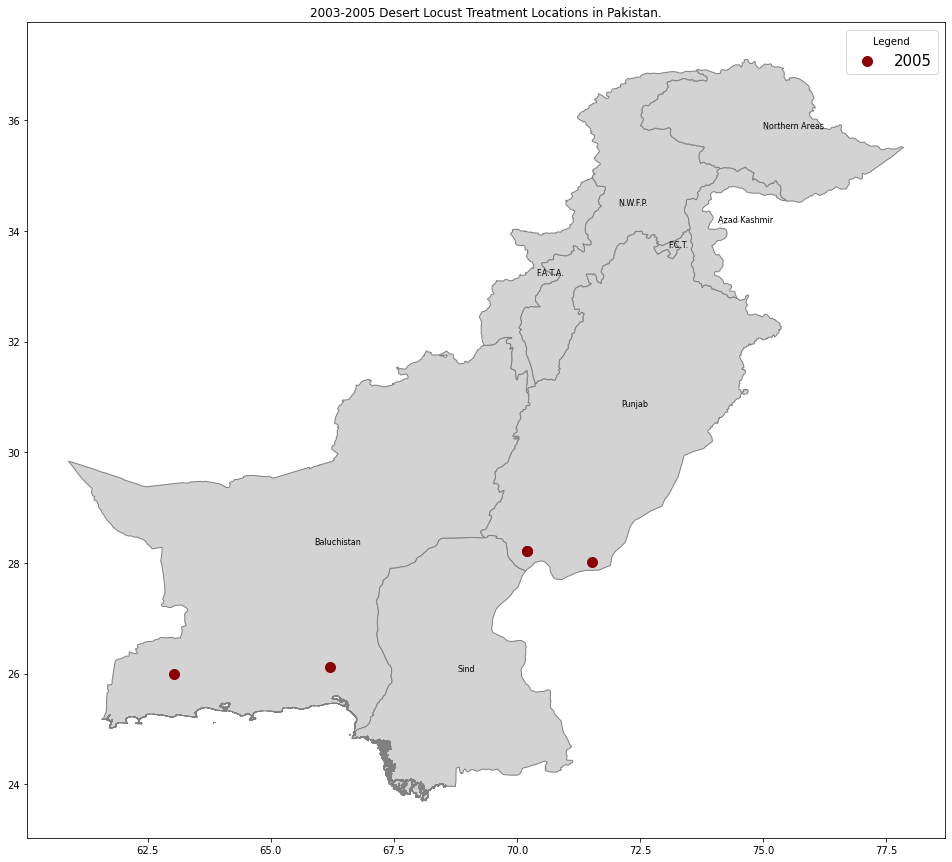

In [106]:
countryPlot(point = gdf_2019_2021,country = "Pakistan", period = "2019-2021")
countryPlot(point = gdf_2003_2005,country = "Pakistan", period = "2003-2005")

In [19]:

# function to check for unique values in a list



def unique(list_):
    unique_list = []
    for item in list_:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list
            

In [40]:
#unique(country_sum.SOVEREIGNT)